In [1]:
import pandas as pd
import os
import json
from  builtins import any as b_any
from csv import writer
import matplotlib.pyplot as plt

## Eurotopics data

In [2]:
eurotopics_data = pd.read_excel(r'/homenfs/l.bellomo1/EU-NewsDataset/mappings/Eurotopics_media_label.xls', index_col=0) 

#### Exploring included EU countries
- selecting only EU countries (and UK) among the avaiable countries

In [3]:
# all countries 
eurotopics_data['Country'].unique()

array(['Egypt', 'Algeria', 'Argentina', 'Australia', 'Belarus', 'Belgium',
       'Benin', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'China', 'Germany', 'Denmark', 'Estonia',
       'Finland', 'France', 'Greece', 'United Kingdom', 'Iraq', 'Ireland',
       'Israel', 'Italy', 'Jordan', 'Canada', 'Qatar', 'Colombia',
       'Croatia', 'Latvia', 'Lebanon', 'Liechtenstein', 'Lithuania',
       'Luxembourg', 'Malta', 'Morocco', 'Mexico', 'Montenegro',
       'Netherlands', 'Nigeria', 'North Macedonia', 'Austria',
       'Palestinian territories', 'Poland', 'Portugal', 'Romania',
       'Russia', 'Saudi Arabia', 'Sweden', 'Switzerland', 'Serbia',
       'Slovakia', 'Slovenia', 'Spain', 'South Korea', 'Czech Republic',
       'Turkey', 'U.S.', 'Ukraine', 'Hungary', 'Cyprus'], dtype=object)

In [4]:
# selecting only EU countries
eu_countries = ['Austria','Belgium','Bulgaria', 'Croatia','Czech Republic', 'Cyprus','Denmark','Estonia','Finland', 'France', 'Greece', 'Germany',  'Hungary','Ireland', 'Italy',  'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands','Poland', 'Portugal', 'Romania', 'Sweden', 'Slovakia', 'Slovenia', 'Spain', 'United Kingdom']
# filtering out not european countries
european_media = eurotopics_data.loc[eurotopics_data.Country.isin(eu_countries)]

In [5]:
# number of media for each european country
european_media.Country.value_counts()

Hungary           47
France            45
Greece            45
Germany           39
Romania           34
United Kingdom    31
Spain             27
Poland            26
Finland           24
Portugal          23
Bulgaria          20
Lithuania         18
Belgium           16
Czech Republic    16
Italy             16
Sweden            15
Austria           15
Latvia            13
Croatia           13
Estonia           13
Slovenia          12
Cyprus            12
Netherlands       12
Slovakia          10
Ireland           10
Denmark           10
Luxembourg         6
Malta              4
Name: Country, dtype: int64

#### Exploring avaiable Frequency of Pubblication of medias
- discarding medias that have a frequency of pubblication equal to ['Monthly','Updated on an irregular basis','Every two months','nan'] to avoid noise in the dataset

In [6]:
european_media['Frequency of publication'].unique()

array(['several times a week', 'Monday to Saturday',
       'Weekly on Wednesdays', 'Daily', 'Weekly on Thursdays',
       'Updated on an irregular basis', nan, 'Monday to Friday',
       'Weekly on Fridays', 'Weekly on Saturdays', 'Monthly',
       'Weekly on Sundays', 'Weekly on Mondays', 'several times a month',
       'Every two months', 'Weekly on Tuesdays', 'weekly'], dtype=object)

In [7]:
european_media = european_media.loc[~european_media['Frequency of publication'].isin(['Monthly','Updated on an irregular basis','Every two months','nan'])]
european_media['Frequency of publication'].value_counts()

Daily                    212
Monday to Saturday        86
several times a week      46
Monday to Friday          34
Weekly on Thursdays       30
Weekly on Fridays         29
Weekly on Sundays         17
Weekly on Wednesdays      13
Weekly on Mondays         11
Weekly on Saturdays        8
several times a month      6
Weekly on Tuesdays         1
weekly                     1
Name: Frequency of publication, dtype: int64

#### Exploring avaiable Area of Distribution of medias
- selecting only medias that have a nationwide Area of Distribution 

In [8]:
european_media['Area of distribution'].unique()

array(['Nationwide', 'Regional', nan], dtype=object)

In [9]:
european_media = european_media.loc[european_media['Area of distribution'] == 'Nationwide']
european_media['Area of distribution'].value_counts()

Nationwide    435
Name: Area of distribution, dtype: int64

#### Exploring avaiable Political Leanings of medias
- selecting only medias that have a not null political leaning and also those that are equal to ['Critical of the government','Pro-government ','Christian','Catholic', 'nationalistisch'] since they are too specific

In [10]:
european_media['Political orientation'].unique()

array(['Centre-left', 'Liberal', 'Left-wing', nan, 'Liberal-conservative',
       'Conservative', 'Critical of the government', 'Pro-government',
       'Christian', 'Right-wing', 'Far left', 'Catholic',
       'nationalistisch'], dtype=object)

In [11]:
# european media which have a political orientation and have a Frequency of publication daily or weekly and Area of distribution = nationwide (not regionally)
european_media = european_media.loc[(european_media['Political orientation'].notnull())  & (~european_media['Political orientation'].isin(['Critical of the government','Pro-government','Christian','Catholic', 'nationalistisch']))]
european_media['Political orientation'].value_counts()

Liberal                 115
Centre-left              69
Conservative             54
Liberal-conservative     41
Left-wing                37
Right-wing               11
Far left                  1
Name: Political orientation, dtype: int64

## Common Crawl Dataset

#### plot utilities

In [12]:
def plot_year_distribution(df):
    
    plt.rcParams["figure.figsize"] = (25,10)
    ax = df.groupby('year')['source_name'].count().plot(kind='bar', stacked=True)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylabel('# articles (millions)', fontsize = 26)
    plt.xlabel('Year', fontsize = 26)                                                                                                                                                                                                                                                                                                      

    rects = ax.patches

    # Make some labels.
    labels = ["label%d" % i for i in range(len(rects))]

    for rect in rects:
        height = rect.get_height()
        label_text = f'{int(height)}'
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label_text,
                ha='center', va='bottom', fontsize=20)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    plt.tight_layout()
    plt.savefig('/homenfs/l.bellomo1/EU-NewsDataset/img/n_articles_year.png')
    plt.show()

In [13]:
def plot_country_media_distribution(df):

    plt.rcParams["figure.figsize"] = (25,10)
    ax = df.groupby(['country','political_leaning'])['source_name'].nunique().unstack().plot(kind='bar', stacked=True)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylabel('# media outlet', fontsize = 26)
    plt.xlabel('Country', fontsize = 26)
    plt.legend(prop={'size': 20}, framealpha=0.2, loc='upper left')

    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        
        # The height of the bar is the data value and can be used as the label
        label_text = f'{int(height)}'  # f'{height:.2f}' to format decimal values

        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2

        # plot only when height is greater than specified value
        if height > 0:
            ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=20, color='black')
    plt.tight_layout()
    plt.savefig('/homenfs/l.bellomo1/EU-NewsDataset/img/n_media_country.png')
    plt.show()

In [14]:
def plot_country_articles_distribution(df):

    plt.rcParams["figure.figsize"] = (25,10)
    ax = df.groupby(['country','political_leaning'])['source_name'].count().unstack().plot(kind='bar', stacked=True)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel('# articles (millions)', fontsize = 20)
    plt.xlabel('Country', fontsize = 20)
    plt.legend(prop={'size': 14}, framealpha=0.2, loc='upper left')

    plt.tight_layout()
    #plt.savefig('/home/morini/mydata/ebu_project/eurotopics_data/articles_country_newattempt.png')
    plt.savefig('/homenfs/l.bellomo1/EU-NewsDataset/img/n_articles_country.png')
    plt.show()

In [15]:
def plot_domain_articles_distribution(df):

    plt.rcParams["figure.figsize"] = (40,10)
    ax = df.groupby(['source_name','political_leaning'])['source_name'].count().unstack().plot(kind='bar', stacked=True)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel('# articles (millions)', fontsize = 20)
    plt.xlabel('Media Outlet', fontsize = 20)
    plt.legend(prop={'size': 14}, framealpha=0.2, loc='upper left')

    plt.tight_layout()
    plt.savefig('/homenfs/l.bellomo1/EU-NewsDataset/img/media_outlet_political_leaning.png')
    plt.show()

In [16]:
def plot_country_media_sources(df): # TODO: I'm not able to plot figure in subplots they remain empty

    countries = list(df.country.unique())
    n_col, n_row = 4, len(countries) // 4
    
    lenght_per_fig, height_per_fig = 10, 30
    fig, ax = plt.subplots(n_row, n_col, figsize=(lenght_per_fig*n_row, height_per_fig*n_col))
    color_map = {
        'Centre-left': 'tab:blue',
        'Liberal': 'tab:red',
        'Conservative': 'tab:orange',
        'Left-wing': 'tab:green',
        'Right-wing': 'tab:brown',
        'Liberal-conservative' : 'tab:purple'
    }

    for i, country in enumerate(countries):
        row = i // n_col
        col = i % n_col 
        tmp = pd.DataFrame(all_data.loc[all_data['country'] == country].groupby(['source_name','political_leaning'])['source_name'].count().unstack())
        tmp = tmp.fillna(0)
        labels = list(tmp.index)
        for political_leaning in list(tmp.columns):
            ax[row, col].bar(labels, tmp[political_leaning].values, label=political_leaning, color=[color_map[political_leaning]])

        ax[row, col].set_title(country, size=40)
        ax[row, col].set_ylabel('# articles (millions)', size=25) 
        ax[row, col].set_xlabel('Media Outlet', size=25) 
        ax[row, col].xaxis.set_tick_params(labelsize=25, rotation=90) 
        ax[row, col].yaxis.set_tick_params(labelsize=25) 
        ax[row, col].legend(prop={"size":20})
        

    fig.tight_layout(pad=1)
    plt.savefig('/homenfs/l.bellomo1/EU-NewsDataset/img/country_media.png')
    fig.show()

In [17]:
def plot_domain_articles_year_distribution(df):

    plt.rcParams["figure.figsize"] = (50,20)
    ax = df.groupby(['source_name','year'])['source_name'].count().unstack().plot(kind='bar', stacked=True)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel('# articles (millions)', fontsize = 20)
    plt.xlabel('Media Outlet', fontsize = 20)
    plt.legend(prop={'size': 14}, framealpha=0.2, loc='upper left')

    plt.tight_layout()
    plt.savefig('/homenfs/l.bellomo1/EU-NewsDataset/img/media_outlet_year.png')
    plt.show()

#### ALL EU DATA: dataset creation and analysis

This dataset contains all articles extracted on common crawls and was obtained by merging 'merged.csv' and 'attempt_2020_dataset.csv'. It will be used to build the training set, the test set biased, the test set non biased
- we have the original dataset (not cleaned) /all_data_eu.csv
- the cleaned dataset was obtained running text_cleaning.py 
- from 2016 to 2021
- 192 media outlets
- 28 countries (27 EU + United Kingdom)
- we drop all nan values
- we plot various type of distribution
- we noticed that some media have the same name, so we decided to remove it to avoid confusion: duplicated_media = ['Deutsche Welle', 'The Herald', 'Delfi', 'Diena', 'Capital','Fokus', 'Kurir', 'Dnevnik', 'ABC', 'Público', 'Metro','Kathimerini', 'Politis']

In [18]:
all_data = pd.read_csv('/homenfs/l.bellomo1/BiasClassification/data/all_data_eu_cleaned.csv') # opening the cleaned file for defining tess sets and training set
#all_data = all_data.loc[all_data.year.isin([2016,2017,2018,2019,2020,2021])]
duplicated_media = ['Deutsche Welle', 'The Herald', 'Delfi', 'Diena', 'Capital',
       'Fokus', 'Kurir', 'Dnevnik', 'ABC', 'Público', 'Metro',
       'Kathimerini', 'Politis']
#all_data = all_data.loc[~all_data.source_name.isin(duplicated_media)]

In [19]:
all_data.political_leaning.value_counts()

Conservative            4553876
Liberal                 3597700
Centre-left             3202951
Left-wing               1531738
Liberal-conservative    1516743
Right-wing              1262787
Name: political_leaning, dtype: int64

In [20]:
print('# media outlets', all_data.source_name.nunique())
print('# country', all_data.country.nunique())
print('country', all_data.country.unique())

# media outlets 192
# country 28
country ['Austria' 'Finland' 'Sweden' 'Germany' 'Portugal' 'France'
 'United Kingdom' 'Hungary' 'Greece' 'Estonia' 'Slovenia' 'Croatia'
 'Spain' 'Ireland' 'Italy' 'Cyprus' 'Malta' 'Luxembourg' 'Belgium'
 'Romania' 'Netherlands' 'Denmark' 'Poland' 'Bulgaria' 'Czech Republic'
 'Latvia' 'Lithuania' 'Slovakia']


In [21]:
all_data.isna().sum()

title                0
maintext             0
date_publish         0
language             0
source_domain        0
id                   0
date                 0
year                 0
source_name          0
political_leaning    0
country              0
dtype: int64

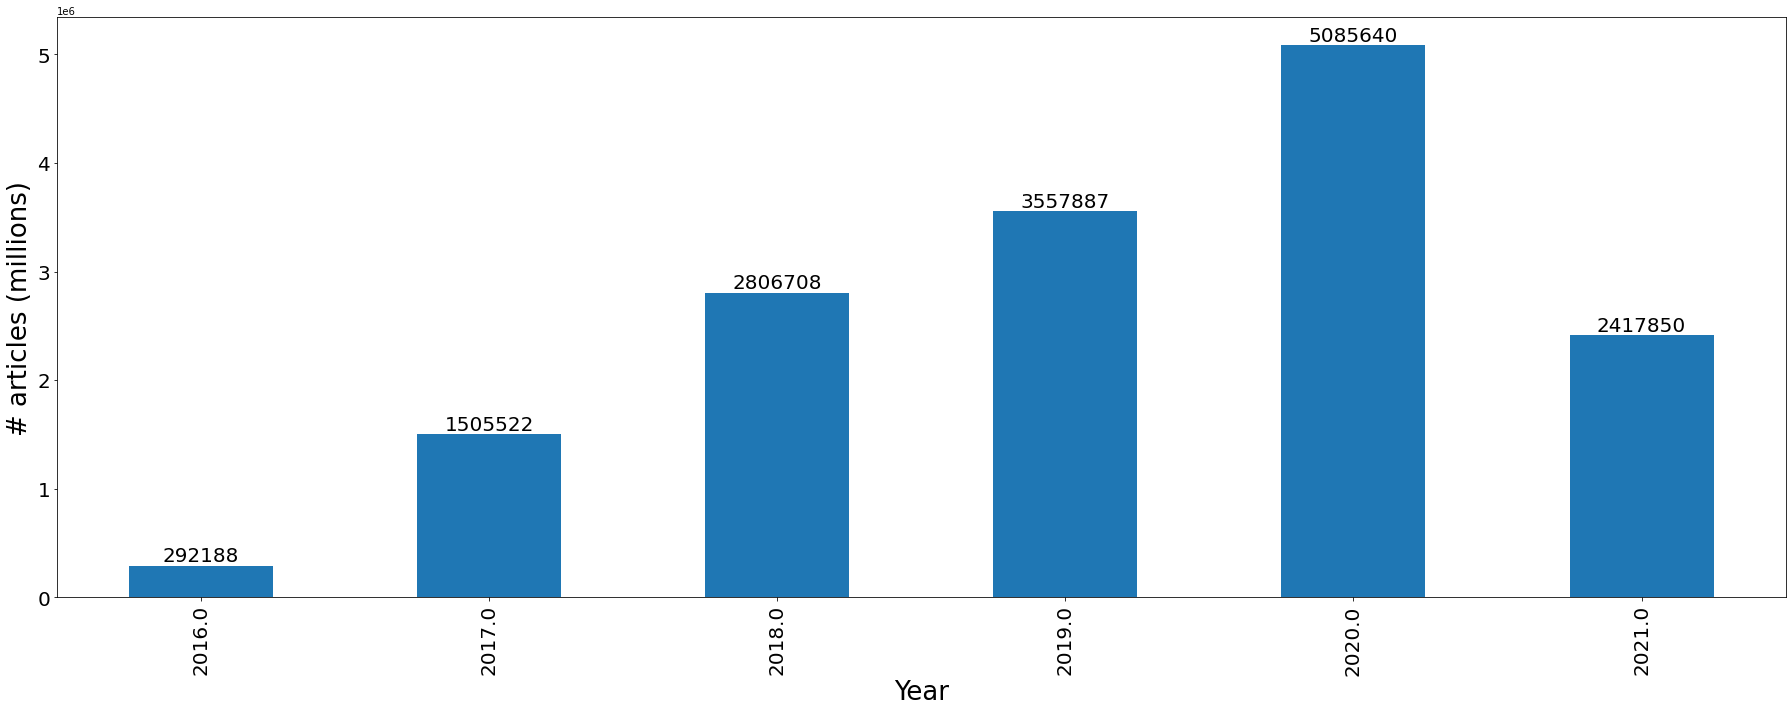

In [22]:
plot_year_distribution(all_data)

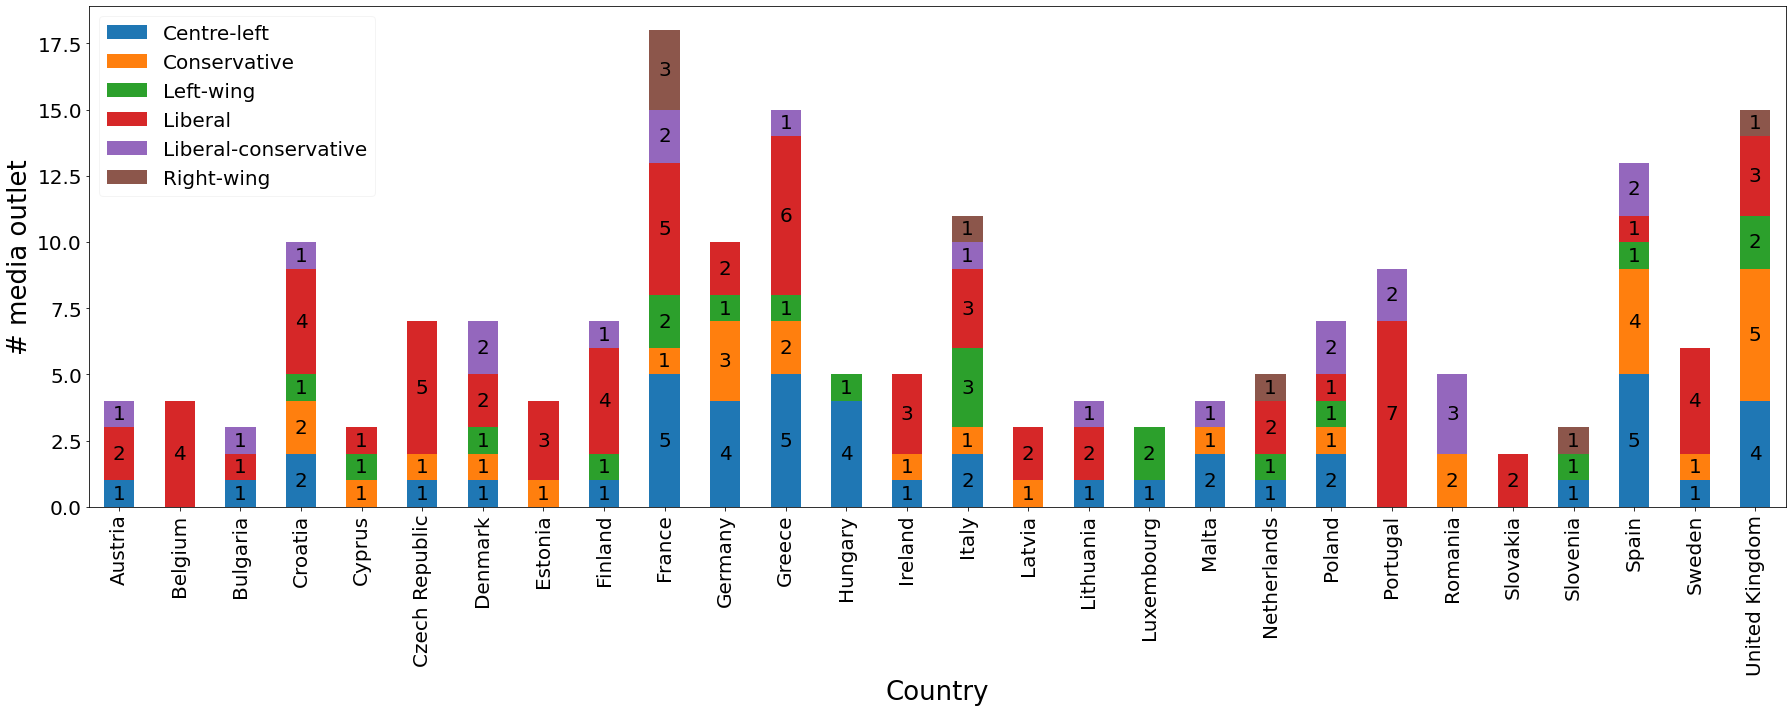

In [23]:
plot_country_media_distribution(all_data)

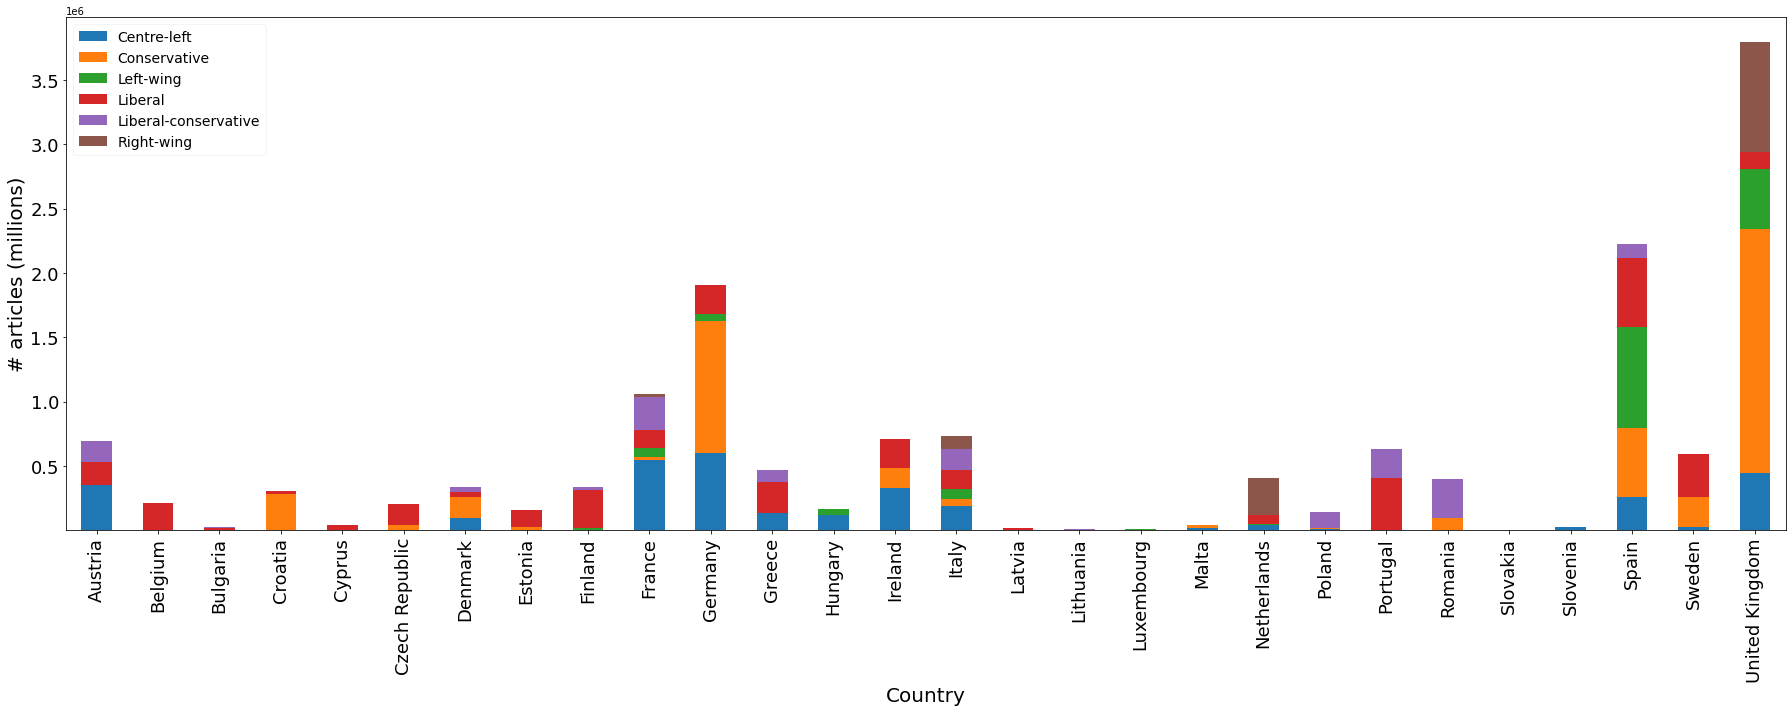

In [24]:
plot_country_articles_distribution(all_data)

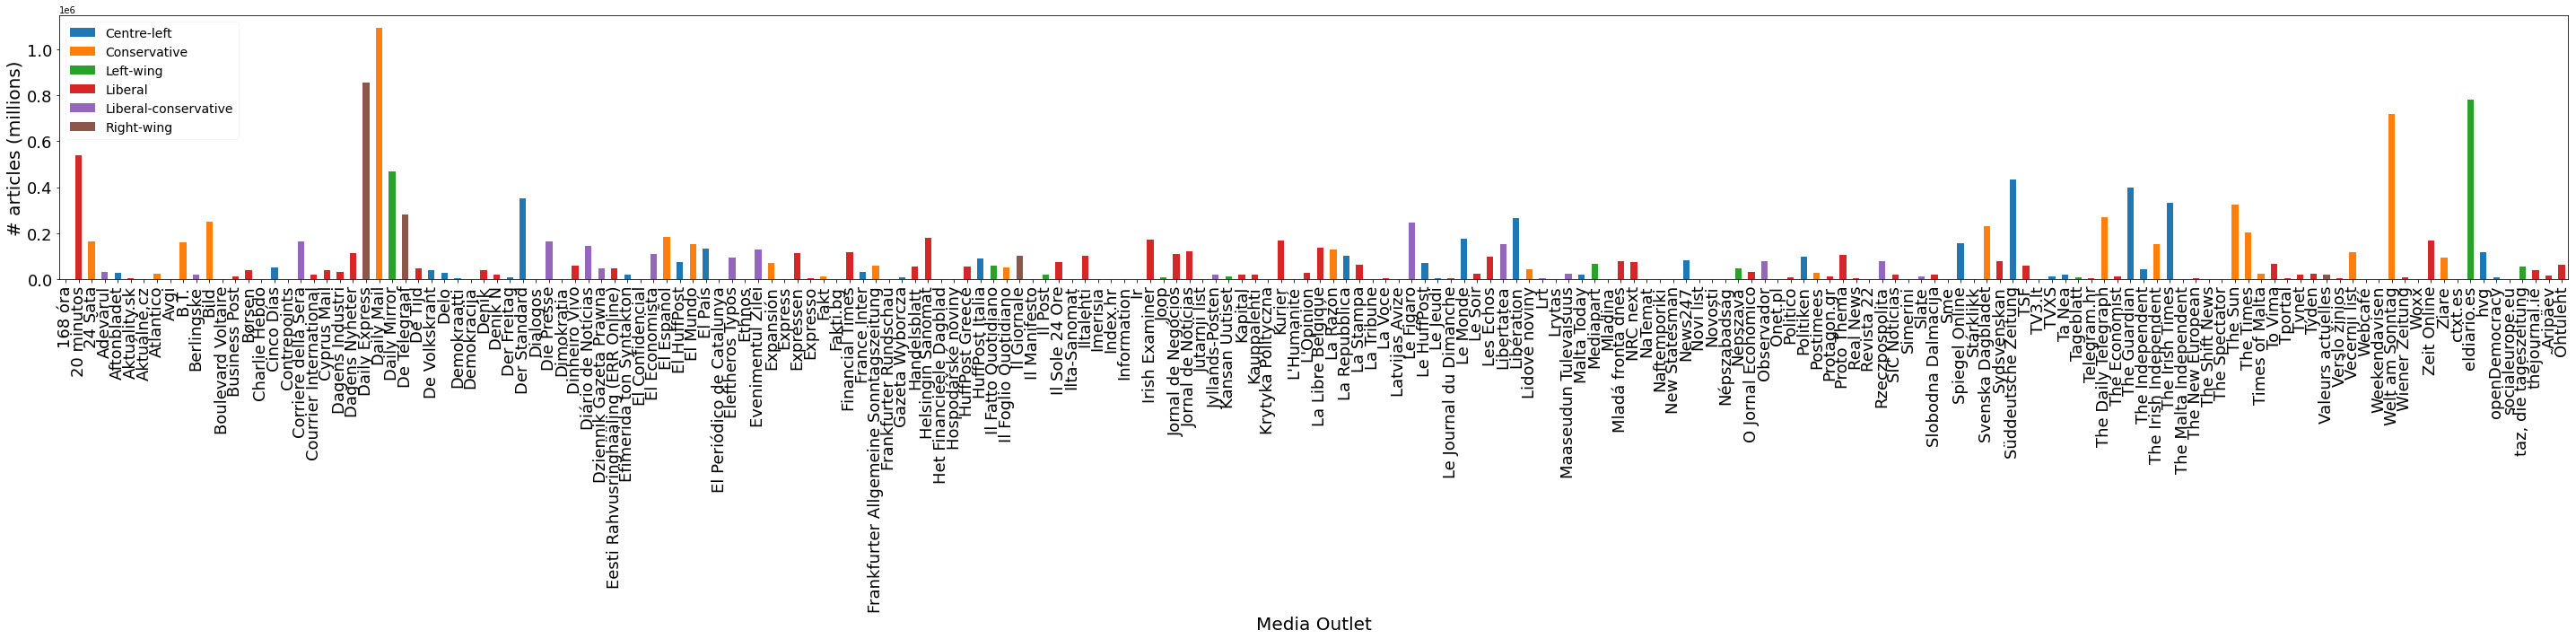

In [25]:
plot_domain_articles_distribution(all_data)

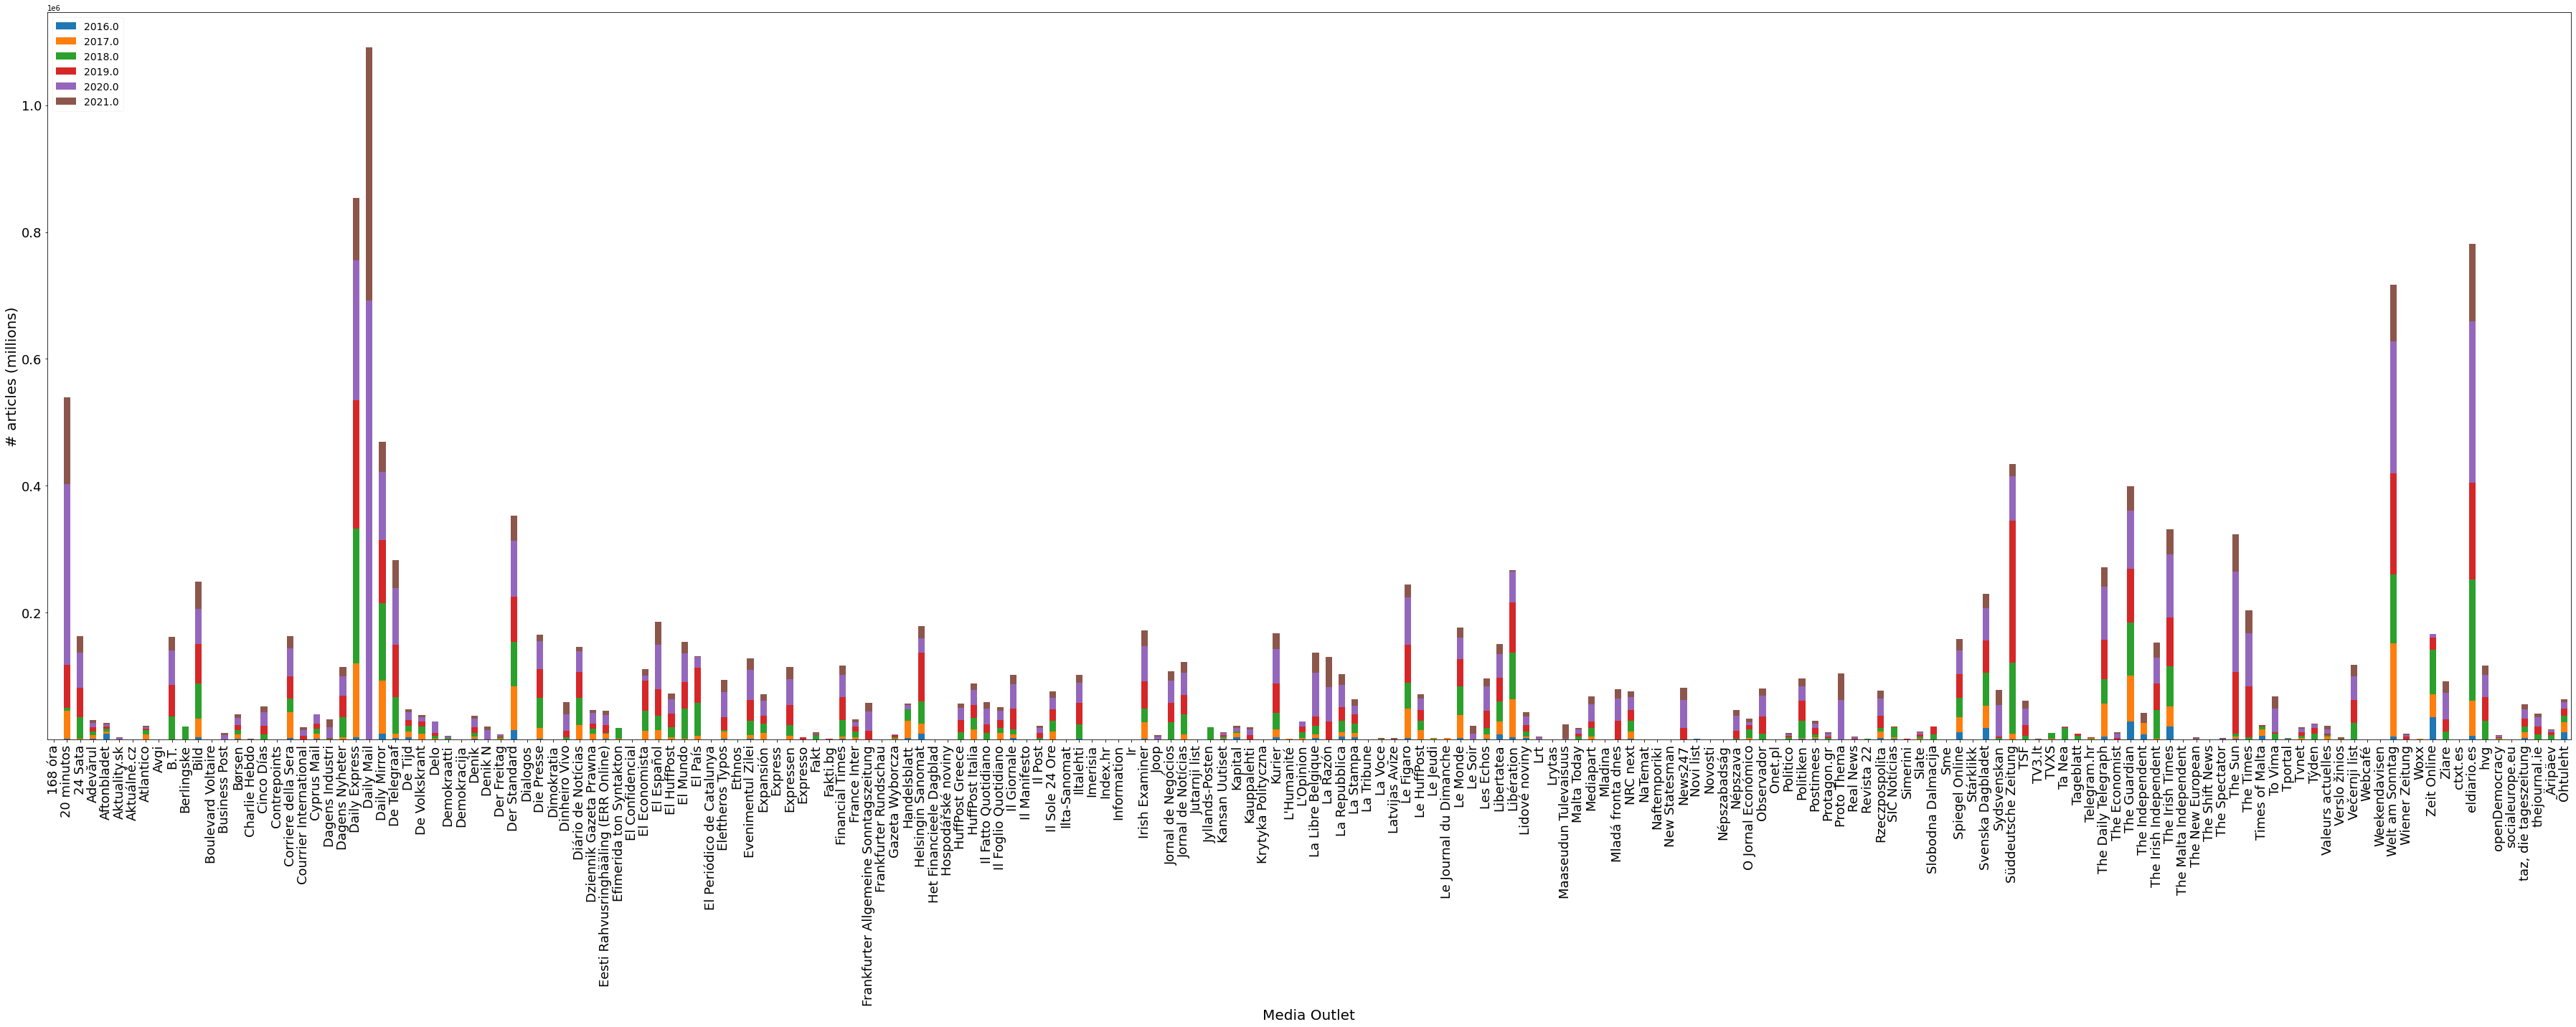

In [26]:
plot_domain_articles_year_distribution(all_data)

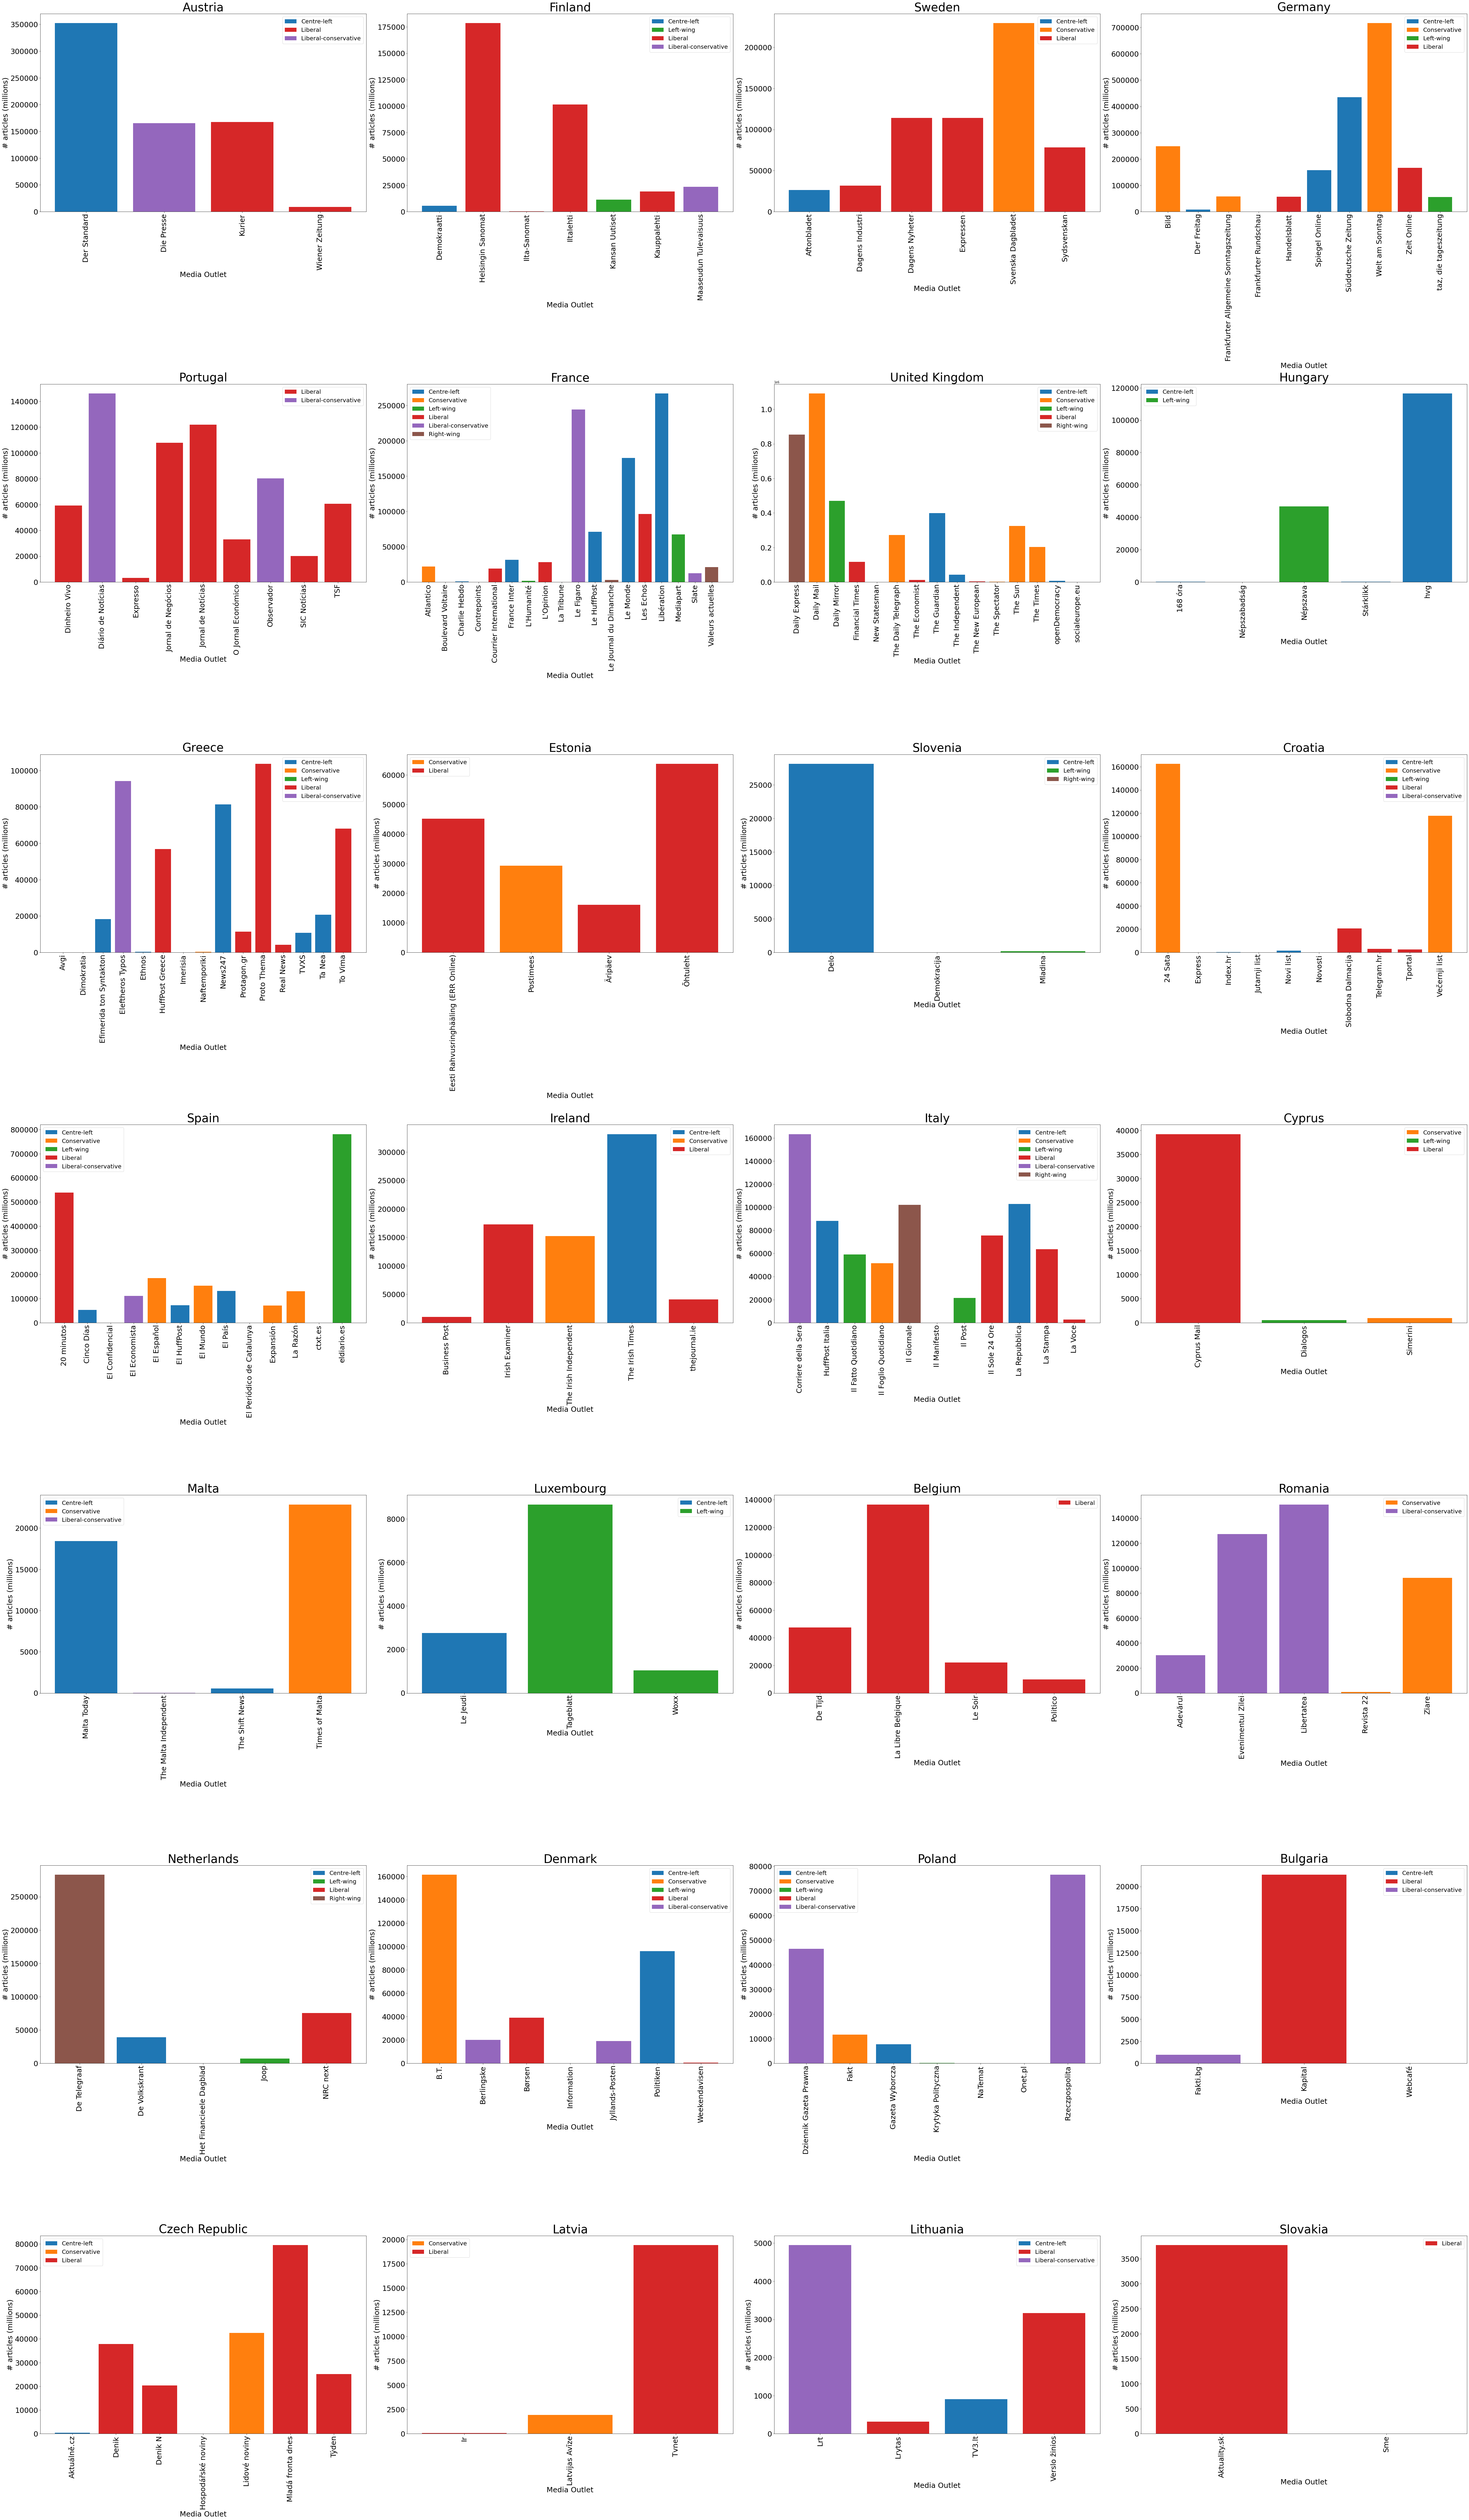

In [27]:
plot_country_media_sources(all_data)